# EVLib with slider_depth Dataset

This notebook demonstrates how to work with the slider_depth dataset using EVLib. We'll explore various visualization techniques and event processing methods to recreate examples similar to those in the event_utils repository.

## Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import evlib
import os
from PIL import Image
import time

# Try to import cv2 for better visualizations
try:
    import cv2
    have_cv2 = True
except ImportError:
    have_cv2 = False
    print("OpenCV not available, some visualizations will be limited")

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib for better visualization
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')

# Set paths
data_path = "../data/slider_depth/"

## 1. Loading the Dataset

First, let's load the dataset files - events, images, calibration, and groundtruth.

Loading events from ../data/slider_depth/events.txt using evlib...
Loaded 1078541 events.
Loading image info from ../data/slider_depth/images.txt...
Found 87 images.
Loading calibration from ../data/slider_depth/calib.txt...
Sensor resolution: 240 x 180


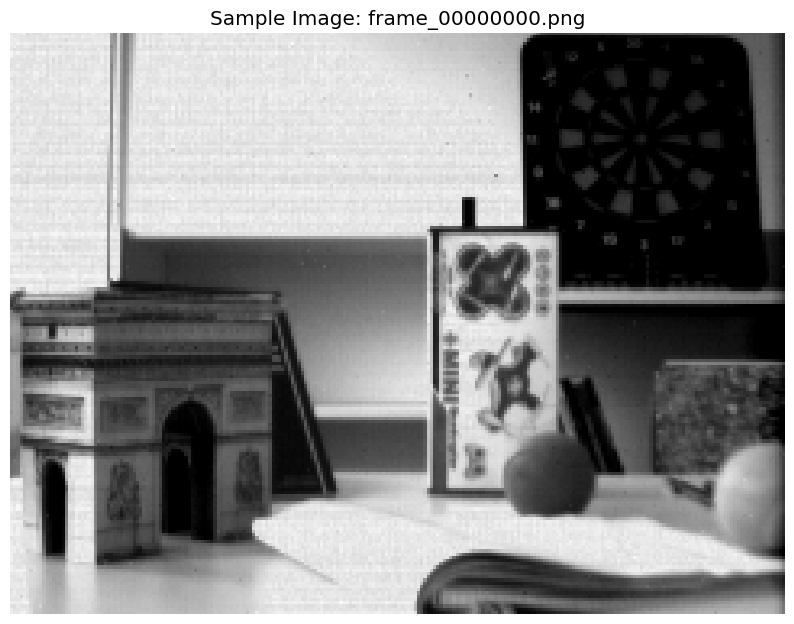

In [2]:
def load_events_from_text(filepath):
    """Deprecated: Load events from a text file using numpy directly"""
    print(f"Loading events from {filepath} using numpy...")
    data = np.loadtxt(filepath)
    print(f"Loaded {len(data)} events.")
    
    # Events file format: timestamp x y polarity
    ts = data[:, 0].astype(np.float64)  # timestamps
    xs = data[:, 1].astype(np.int64)    # x coordinates
    ys = data[:, 2].astype(np.int64)    # y coordinates
    ps = data[:, 3].astype(np.int64)    # polarities
    
    return xs, ys, ts, ps

def load_events(filepath, **kwargs):
    """Load events using evlib's formats module"""
    print(f"Loading events from {filepath} using evlib...")
    # Use evlib's data loader which automatically detects the file format
    xs, ys, ts, ps = evlib.formats.load_events_py(filepath, **kwargs)
    print(f"Loaded {len(xs)} events.")
    return xs, ys, ts, ps

def load_images(image_txt_path):
    """Load image timestamps and paths"""
    print(f"Loading image info from {image_txt_path}...")
    with open(image_txt_path, 'r') as f:
        lines = f.readlines()
    
    img_timestamps = []
    img_paths = []
    
    for line in lines:
        parts = line.strip().split()
        if len(parts) == 2:
            img_timestamps.append(float(parts[0]))
            img_paths.append(parts[1])
    
    print(f"Found {len(img_timestamps)} images.")
    return img_timestamps, img_paths

def load_calibration(calib_path):
    """Load camera calibration parameters"""
    print(f"Loading calibration from {calib_path}...")
    with open(calib_path, 'r') as f:
        line = f.readline()
    
    params = [float(val) for val in line.strip().split()]
    if len(params) >= 9:
        calib = {
            'fx': params[0],
            'fy': params[1],
            'cx': params[2],
            'cy': params[3],
            'k1': params[4],
            'k2': params[5],
            'p1': params[6],
            'p2': params[7],
            'k3': params[8] if len(params) > 8 else 0.0
        }
    else:
        calib = {}
        print("Warning: Could not parse calibration parameters correctly.")
    
    return calib

# Load the dataset using evlib's data loader
events_path = os.path.join(data_path, "events.txt")
xs, ys, ts, ps = load_events(events_path)

# Load image info and calibration
img_timestamps, img_paths = load_images(os.path.join(data_path, "images.txt"))
calibration = load_calibration(os.path.join(data_path, "calib.txt"))

# Determine sensor resolution
sensor_width = xs.max() + 1
sensor_height = ys.max() + 1
print(f"Sensor resolution: {sensor_width} x {sensor_height}")

# Load one image to visualize
sample_img_path = os.path.join(data_path, img_paths[0])
sample_img = np.array(Image.open(sample_img_path))

# Show image
plt.figure(figsize=(10, 8))
plt.imshow(sample_img, cmap='gray')
plt.title(f"Sample Image: {os.path.basename(img_paths[0])}")
plt.axis('off')
plt.show()

## 2. Basic Event Visualization

Let's visualize the events in different ways. First, we'll create a function to generate event frames.

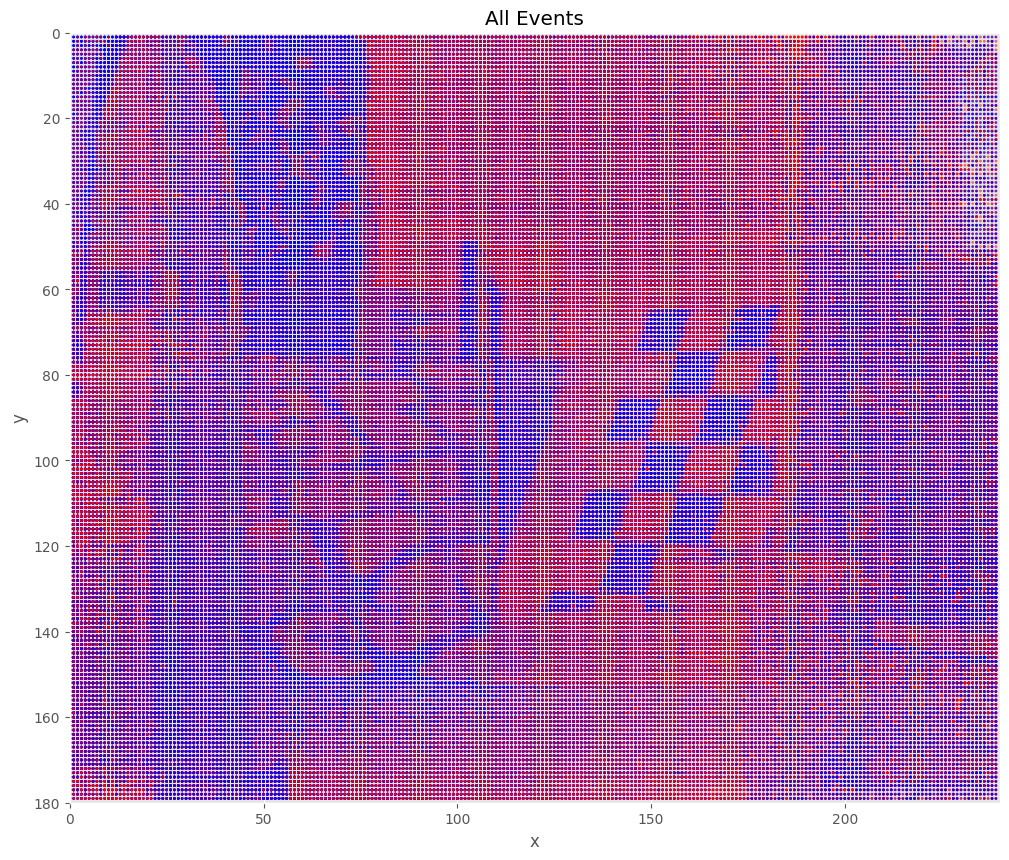

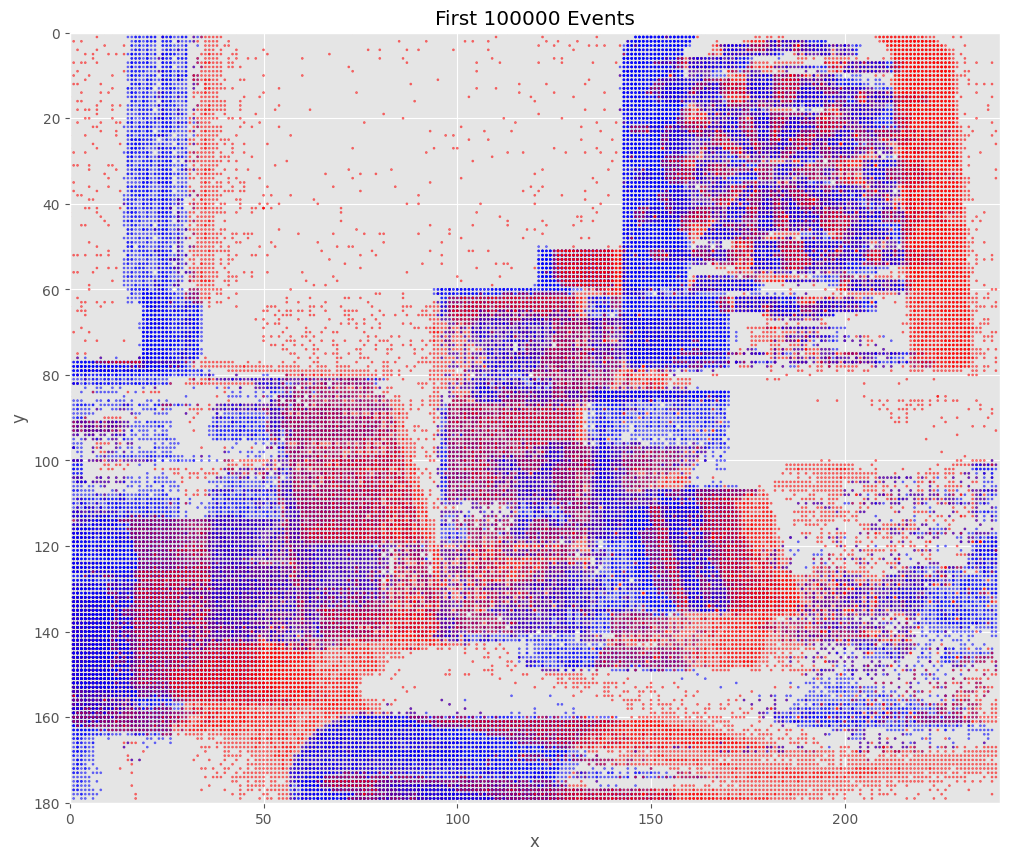

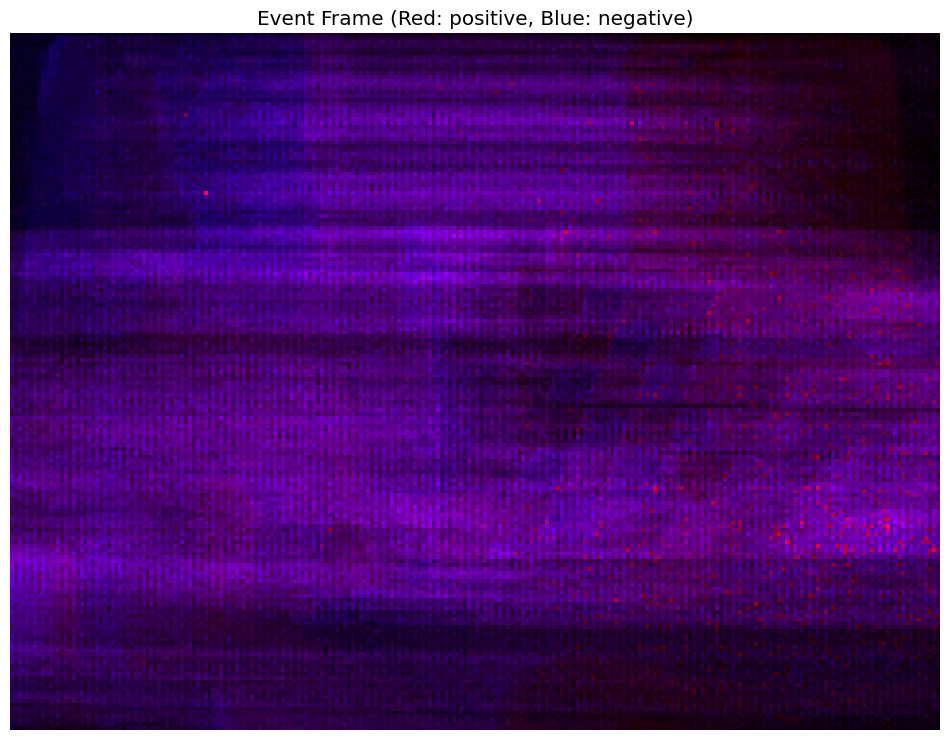

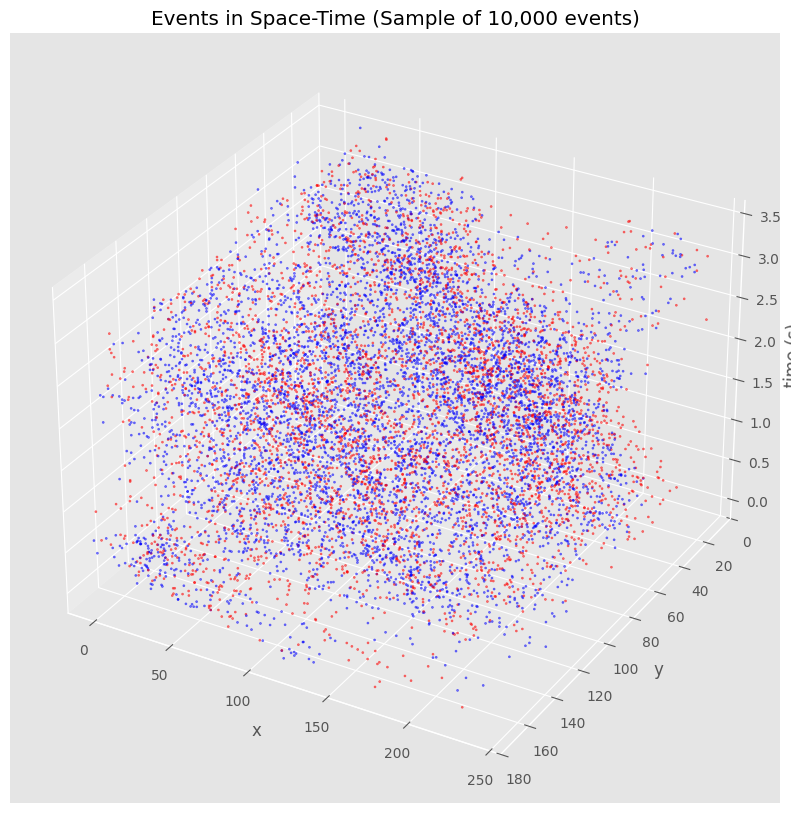

In [3]:
def visualize_events_2d(xs, ys, ps, resolution=(None, None), ax=None, title="Events"):
    """Create a 2D visualization of events with red/blue colors for polarities"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 10))
    
    # Determine resolution if not provided
    width = resolution[0] if resolution[0] is not None else xs.max() + 1
    height = resolution[1] if resolution[1] is not None else ys.max() + 1
    
    # Prepare colors: red for positive, blue for negative
    colors = np.array(['r' if p > 0 else 'b' for p in ps])
    
    # Plot events
    ax.scatter(xs, ys, c=colors, s=2, alpha=0.5)
    ax.set_xlim(0, width)
    ax.set_ylim(height, 0)  # Invert y-axis to match image coordinates
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    return ax

def visualize_events_3d(xs, ys, ts, ps, resolution=(None, None), ax=None, 
                       title="Events in Space-Time", max_events=None):
    """Create a 3D visualization of events in space-time"""
    if ax is None:
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')
    
    # Limit the number of events for better visualization
    if max_events is not None and len(xs) > max_events:
        # Sample events uniformly
        idx = np.linspace(0, len(xs)-1, max_events, dtype=int)
        xs_sub = xs[idx]
        ys_sub = ys[idx]
        ts_sub = ts[idx]
        ps_sub = ps[idx]
    else:
        xs_sub, ys_sub, ts_sub, ps_sub = xs, ys, ts, ps
    
    # Prepare colors: red for positive, blue for negative
    colors = np.array(['r' if p > 0 else 'b' for p in ps_sub])
    
    # Plot events in 3D space-time
    ax.scatter(xs_sub, ys_sub, ts_sub, c=colors, s=2, alpha=0.5)
    
    # Set labels and title
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('time (s)')
    ax.set_title(title)
    
    # Invert y-axis to match image coordinates
    ax.set_ylim(resolution[1] if resolution[1] is not None else ys.max() + 1, 0)
    
    return ax

def create_event_frame(xs, ys, ps, resolution, mode="polarity", normalize=True):
    """Create an event frame with different accumulation modes"""
    width, height = resolution
    
    if mode == "polarity":
        # Accumulate polarities (positive and negative)
        frame = np.zeros((height, width), dtype=np.float32)
        for x, y, p in zip(xs, ys, ps):
            if 0 <= x < width and 0 <= y < height:
                frame[y, x] += p
    
    elif mode == "count":
        # Count events regardless of polarity
        frame = np.zeros((height, width), dtype=np.float32)
        for x, y in zip(xs, ys):
            if 0 <= x < width and 0 <= y < height:
                frame[y, x] += 1
    
    elif mode == "separate":
        # Create separate channels for positive and negative events
        frame = np.zeros((height, width, 3), dtype=np.float32)
        for x, y, p in zip(xs, ys, ps):
            if 0 <= x < width and 0 <= y < height:
                if p > 0:
                    frame[y, x, 0] += 1  # Red for positive
                else:
                    frame[y, x, 2] += 1  # Blue for negative
        
        # Normalize each channel separately if requested
        if normalize:
            for c in range(3):
                if frame[:,:,c].max() > 0:
                    frame[:,:,c] /= frame[:,:,c].max()
            return frame
    
    # Normalize frame if requested
    if normalize and frame.max() > 0:
        frame = frame / frame.max()
    
    return frame

# Visualize all events
visualize_events_2d(xs, ys, ps, resolution=(sensor_width, sensor_height), title="All Events")
plt.show()

# Visualize a slice of events (first 100,000)
num_display = min(100000, len(xs))
visualize_events_2d(xs[:num_display], ys[:num_display], ps[:num_display], 
                   resolution=(sensor_width, sensor_height),
                   title=f"First {num_display} Events")
plt.show()

# Create and visualize event frame
event_frame = create_event_frame(xs, ys, ps, (sensor_width, sensor_height), mode="separate")
plt.figure(figsize=(12, 10))
plt.imshow(event_frame)
plt.title("Event Frame (Red: positive, Blue: negative)")
plt.axis('off')
plt.show()

# 3D visualization of a subset of events
visualize_events_3d(xs, ys, ts, ps, resolution=(sensor_width, sensor_height), max_events=10000, 
                   title="Events in Space-Time (Sample of 10,000 events)")
plt.show()

## 3. Time Surface Representation

Time surfaces represent the timestamp of the most recent event at each pixel, creating a 2D representation that encodes temporal information.

In [ ]:
def create_time_surface(xs, ys, ts, ps, resolution, decay=0.05, polarities="separate"):
    """Create a time surface from events
    
    Args:
        decay: Controls the decay rate (in seconds) of the exponential function
        polarities: "separate" for separate pos/neg surfaces, "combined" for a single surface
    """
    width, height = resolution
    
    # In newer versions of evlib, we could use:
    # timestamp_image = evlib.representations.events_to_timestamp_image(
    #    events, resolution, normalize=True, polarity_separate=True)
    # But for now, we'll implement it directly
    
    latest_t = ts.max()
    
    # Initialize time surfaces
    time_surface_pos = np.zeros((height, width))
    time_surface_neg = np.zeros((height, width))
    
    # Process events
    for x, y, t, p in zip(xs, ys, ts, ps):
        if 0 <= x < width and 0 <= y < height:
            # Calculate exponential decay
            decay_val = np.exp(-(latest_t - t) / decay)
            
            if p > 0:
                time_surface_pos[y, x] = decay_val
            else:
                time_surface_neg[y, x] = decay_val
    
    if polarities == "separate":
        # Return RGB image: R=positive events, B=negative events
        time_surface_rgb = np.zeros((height, width, 3))
        time_surface_rgb[:, :, 0] = time_surface_pos  # Red for positive
        time_surface_rgb[:, :, 2] = time_surface_neg  # Blue for negative
        return time_surface_rgb
    else:
        # Return combined time surface (max of positive and negative)
        return np.maximum(time_surface_pos, time_surface_neg)

## 4. Event Slices and Temporal Processing

Let's visualize the events in time slices to understand their temporal distribution.

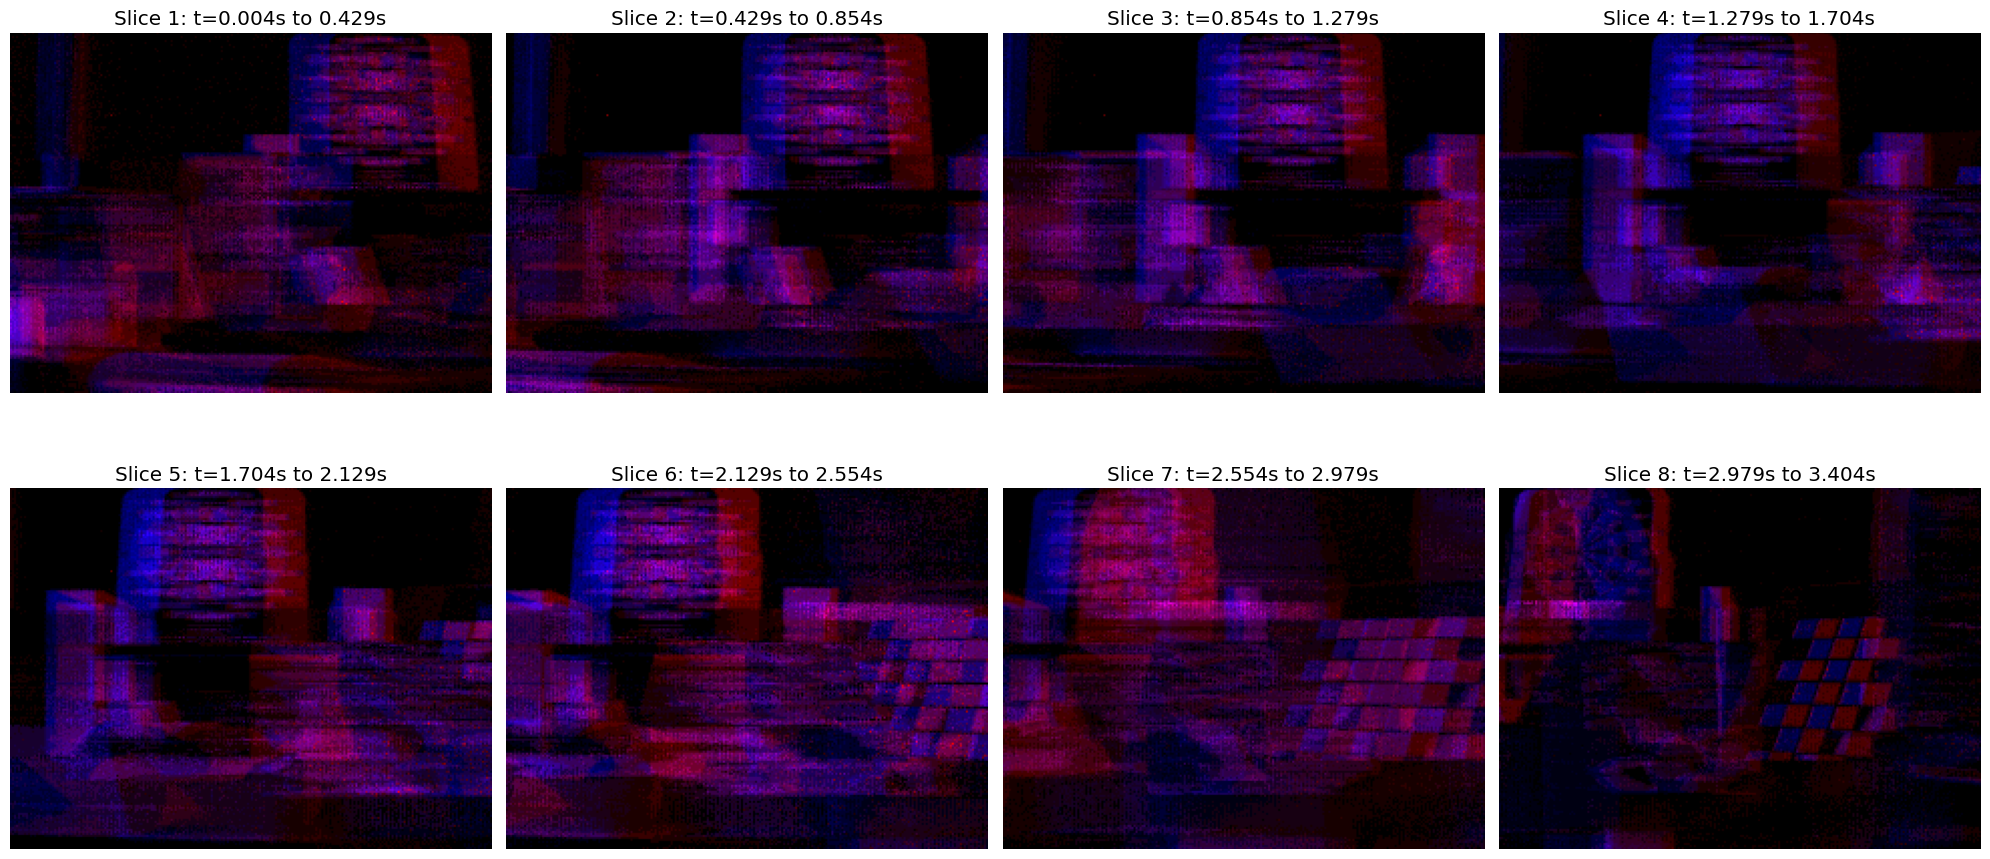

In [5]:
def create_event_slices(xs, ys, ts, ps, resolution, num_slices=10):
    """Split events into time slices and create visualization for each"""
    width, height = resolution
    
    # Calculate time range and bin edges
    t_min, t_max = ts.min(), ts.max()
    bins = np.linspace(t_min, t_max, num_slices + 1)
    
    slices = []
    for i in range(num_slices):
        t_start, t_end = bins[i], bins[i+1]
        idx = (ts >= t_start) & (ts < t_end)
        
        # Extract events in this time slice
        slice_xs = xs[idx]
        slice_ys = ys[idx]
        slice_ps = ps[idx]
        
        # Create image for this slice
        frame = create_event_frame(slice_xs, slice_ys, slice_ps, (width, height), mode="separate")
        slices.append((frame, t_start, t_end))
    
    return slices

# Create event slices
event_slices = create_event_slices(xs, ys, ts, ps, (sensor_width, sensor_height), num_slices=8)

# Visualize the slices
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (frame, t_start, t_end) in enumerate(event_slices):
    axes[i].imshow(frame)
    axes[i].set_title(f"Slice {i+1}: t={t_start:.3f}s to {t_end:.3f}s")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Create animation of event slices
fig, ax = plt.subplots(figsize=(12, 10))
plt.close()  # Don't display the static plot

# Function to update the plot for each frame
def update(i):
    ax.clear()
    frame, t_start, t_end = event_slices[i]
    ax.imshow(frame)
    ax.set_title(f"Slice {i+1}: t={t_start:.3f}s to {t_end:.3f}s")
    ax.axis('off')
    return [ax]

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(event_slices), interval=500, blit=True)

# Display animation in the notebook
from IPython.display import HTML
HTML(ani.to_jshtml())

## 5. Event Augmentation

Let's demonstrate various event augmentation techniques that EVLib provides.

In [ ]:
# Section to test various augmentations

# Define sensor resolution
sensor_resolution = (sensor_width, sensor_height)

# Take a portion of events for simpler visualization
slice_size = 100000  # Number of events to use
slice_start = 0
slice_end = min(slice_start + slice_size, len(xs))

xs_slice = xs[slice_start:slice_end]
ys_slice = ys[slice_start:slice_end]
ts_slice = ts[slice_start:slice_end]
ps_slice = ps[slice_start:slice_end]

# Note: In newer versions of evlib, augmentation functions are in the augmentation submodule
try:
    # 1. Add random noise events
    xs_noise, ys_noise, ts_noise, ps_noise = evlib.augmentation.add_random_events_py(
        xs_slice, ys_slice, ts_slice, ps_slice, to_add=slice_size//2
    )

    # 2. Add correlated noise (follows the pattern of existing events)
    xs_corr, ys_corr, ts_corr, ps_corr = evlib.augmentation.add_correlated_events(
        xs_slice, ys_slice, ts_slice, ps_slice, 
        to_add=slice_size//2, 
        xy_std=3.0, ts_std=0.001
    )

    # 3. Remove events randomly
    xs_removed, ys_removed, ts_removed, ps_removed = evlib.core.remove_events(
        xs_slice, ys_slice, ts_slice, ps_slice, 
        to_remove=slice_size//3
    )

    # 4. Flip events along the x-axis
    xs_flipped_x, ys_flipped_x, ts_flipped_x, ps_flipped_x = evlib.augmentation.flip_events_x(
        xs_slice, ys_slice, ts_slice, ps_slice, 
        sensor_resolution
    )

    # 5. Flip events along the y-axis
    xs_flipped_y, ys_flipped_y, ts_flipped_y, ps_flipped_y = evlib.augmentation.flip_events_y(
        xs_slice, ys_slice, ts_slice, ps_slice, 
        sensor_resolution
    )

    # 6. Rotate events
    rotation_deg = 45
    center = (sensor_width // 2, sensor_height // 2)
    xs_rotated, ys_rotated, ts_rotated, ps_rotated = evlib.augmentation.rotate_events(
        xs_slice, ys_slice, ts_slice, ps_slice, 
        sensor_resolution=sensor_resolution,
        theta_radians=np.radians(rotation_deg),
        center_of_rotation=center
    )

    # Create visualization
    augmentations = [
        (xs_slice, ys_slice, ps_slice, "Original Events"),
        (xs_noise, ys_noise, ps_noise, "With Random Noise"),
        (xs_corr, ys_corr, ps_corr, "With Correlated Noise"),
        (xs_removed, ys_removed, ps_removed, "With Events Removed"),
        (xs_flipped_x, ys_flipped_x, ps_flipped_x, "Flipped X"),
        (xs_flipped_y, ys_flipped_y, ps_flipped_y, "Flipped Y"),
        (xs_rotated, ys_rotated, ps_rotated, f"Rotated {rotation_deg}°")
    ]

    # Visualize all augmentations
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    for i, (x, y, p, title) in enumerate(augmentations):
        if i < len(axes):
            frame = create_event_frame(x, y, p, resolution=sensor_resolution, mode="separate")
            axes[i].imshow(frame)
            axes[i].set_title(title)
            axes[i].axis('off')

    # Hide the last empty subplot if there is one
    if len(augmentations) < len(axes):
        axes[-1].axis('off')

    plt.tight_layout()
    plt.show()

except AttributeError as e:
    print(f"Error accessing augmentation functions: {e}")
    print("\nNote: The evlib API has been updated to use submodules for better organization.")
    print("For the augmentation functions, use:")
    print("  - evlib.augmentation.add_random_events_py()")
    print("  - evlib.augmentation.add_correlated_events()")
    print("  - evlib.core.remove_events()")
    print("  - evlib.augmentation.flip_events_x()/flip_events_y()")
    print("  - evlib.augmentation.rotate_events()")

def create_augmentation_mosaic(xs, ys, ts, ps, resolution):
    """Create a mosaic of augmented event visualizations"""
    width, height = resolution
    
    # Define augmentations to apply
    augmentations = [
        ("Original", lambda x, y, t, p: (x, y, t, p)),
        
        ("Random Noise", 
         lambda x, y, t, p: evlib.add_random_events(x, y, t, p, to_add=len(x)//3)),
        
        ("Correlated Noise", 
         lambda x, y, t, p: evlib.add_correlated_events(x, y, t, p, to_add=len(x)//3, xy_std=2.0, ts_std=0.001)),
        
        ("Removed Events", 
         lambda x, y, t, p: evlib.remove_events(x, y, t, p, to_remove=len(x)//3)),
        
        ("Flipped X", 
         lambda x, y, t, p: evlib.flip_events_x(x, y, t, p, resolution=(height, width))),
        
        ("Flipped Y", 
         lambda x, y, t, p: evlib.flip_events_y(x, y, t, p, resolution=(height, width))),
        
        ("Rotated 45°", 
         lambda x, y, t, p: evlib.rotate_events(x, y, t, p, 
                                              sensor_resolution=(height, width),
                                              theta_radians=np.radians(45),
                                              center_of_rotation=(width//2, height//2))),
        
        ("Rotated 90°", 
         lambda x, y, t, p: evlib.rotate_events(x, y, t, p, 
                                              sensor_resolution=(height, width),
                                              theta_radians=np.radians(90),
                                              center_of_rotation=(width//2, height//2))),
    ]
    
    # Apply all augmentations
    augmented_events = []
    for title, augment_fn in augmentations:
        t_start = time.time()
        x_aug, y_aug, t_aug, p_aug = augment_fn(xs, ys, ts, ps)
        t_elapsed = time.time() - t_start
        
        # Create event frame for visualization
        frame = create_event_frame(x_aug, y_aug, p_aug, resolution=resolution, mode="separate")
        augmented_events.append((title, frame, t_elapsed))
        print(f"Applied {title}: {len(x_aug)} events in {t_elapsed:.3f}s")
    
    # Create the mosaic
    rows = 2
    cols = (len(augmented_events) + rows - 1) // rows
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
    axes = axes.flatten()
    
    for i, (title, frame, t_elapsed) in enumerate(augmented_events):
        if i < len(axes):
            axes[i].imshow(frame)
            axes[i].set_title(f"{title}\n({t_elapsed:.3f}s)")
            axes[i].axis('off')
    
    # Hide any unused axes
    for i in range(len(augmented_events), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    return fig

# Create the augmentation mosaic using a subset of events
sample_size = 20000
if len(xs) > sample_size:
    # Take a time-ordered sample for better visualization
    sorted_idx = np.argsort(ts)[:sample_size]
    xs_sample = xs[sorted_idx]
    ys_sample = ys[sorted_idx]
    ts_sample = ts[sorted_idx]
    ps_sample = ps[sorted_idx]
else:
    xs_sample, ys_sample, ts_sample, ps_sample = xs, ys, ts, ps

# Create the mosaic
print(f"Creating augmentation mosaic with {len(xs_sample)} events...")
fig = create_augmentation_mosaic(xs_sample, ys_sample, ts_sample, ps_sample, 
                               resolution=(sensor_width, sensor_height))

# Save the figure for reference
fig.savefig("augmentation_mosaic.png", dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
def create_augmentation_mosaic(xs, ys, ts, ps, resolution):
    """Create a mosaic of augmented event visualizations"""
    sensor_width, sensor_height = resolution
    
    # Define augmentations to apply with updated API paths
    augmentations = [
        ("Original", lambda x, y, t, p: (x, y, t, p)),
        ("Random Noise", 
         lambda x, y, t, p: evlib.augmentation.add_random_events_py(x, y, t, p, to_add=len(x)//3)),
        ("Correlated Noise", 
         lambda x, y, t, p: evlib.augmentation.add_correlated_events(x, y, t, p, to_add=len(x)//3, xy_std=2.0, ts_std=0.001)),
        ("Removed Events", 
         lambda x, y, t, p: evlib.core.remove_events(x, y, t, p, to_remove=len(x)//3)),
        ("Flipped X", 
         lambda x, y, t, p: evlib.augmentation.flip_events_x(x, y, t, p, resolution)),
        ("Flipped Y", 
         lambda x, y, t, p: evlib.augmentation.flip_events_y(x, y, t, p, resolution)),
        ("Rotated 45°", 
         lambda x, y, t, p: evlib.augmentation.rotate_events(x, y, t, p, 
                                              sensor_resolution=resolution,
                                              theta_radians=np.radians(45),
                                              center_of_rotation=(sensor_width//2, sensor_height//2))),
        ("Rotated 90°", 
         lambda x, y, t, p: evlib.augmentation.rotate_events(x, y, t, p, 
                                              sensor_resolution=resolution,
                                              theta_radians=np.radians(90),
                                              center_of_rotation=(sensor_width//2, sensor_height//2))),
    ]
    
    # Apply all augmentations
    augmented_events = []
    for title, augment_fn in augmentations:
        t_start = time.time()
        try:
            x_aug, y_aug, t_aug, p_aug = augment_fn(xs, ys, ts, ps)
            t_elapsed = time.time() - t_start
            
            frame = create_event_frame(x_aug, y_aug, p_aug, resolution=resolution, mode="separate")
            augmented_events.append((title, frame, t_elapsed))
            print(f"Applied {title}: {len(x_aug)} events in {t_elapsed:.3f}s")
        except Exception as e:
            print(f"Error applying {title}: {e}")
    
    # Create the mosaic
    if not augmented_events:
        print("No augmentations were successful. Please check the API paths.")
        return None
        
    rows = 2
    cols = (len(augmented_events) + rows - 1) // rows
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
    axes = axes.flatten()
    
    for i, (title, frame, t_elapsed) in enumerate(augmented_events):
        if i < len(axes):
            axes[i].imshow(frame)
            axes[i].set_title(f"{title}\n({t_elapsed:.3f}s)")
            axes[i].axis('off')
    
    # Hide any unused axes
    for i in range(len(augmented_events), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    return fig

# Create the augmentation mosaic
# Using a sample of events for better performance
sample_size = 50000
if len(xs) > sample_size:
    sample_indices = np.random.choice(len(xs), sample_size, replace=False)
    xs_sample = xs[sample_indices]
    ys_sample = ys[sample_indices]
    ts_sample = ts[sample_indices]
    ps_sample = ps[sample_indices]
else:
    xs_sample, ys_sample, ts_sample, ps_sample = xs, ys, ts, ps

# Sort by timestamp
sorted_idx = np.argsort(ts_sample)
xs_sample = xs_sample[sorted_idx]
ys_sample = ys_sample[sorted_idx]
ts_sample = ts_sample[sorted_idx]
ps_sample = ps_sample[sorted_idx]

print("Creating augmentation mosaic...")
try:
    # Create the mosaic
    fig = create_augmentation_mosaic(xs_sample, ys_sample, ts_sample, ps_sample, 
                                    resolution=(sensor_width, sensor_height))
    
    if fig:
        # Save the figure for reference
        fig.savefig("augmentation_mosaic.png", dpi=150, bbox_inches='tight')
        plt.show()
except Exception as e:
    print(f"Error creating augmentation mosaic: {e}")
    print("\nNote: The evlib API has been updated to use submodules for better organization.")
    print("For the augmentation functions, use:")
    print("  - evlib.augmentation.add_random_events_py()")
    print("  - evlib.augmentation.add_correlated_events()")
    print("  - evlib.core.remove_events()")
    print("  - evlib.augmentation.flip_events_x()/flip_events_y()")
    print("  - evlib.augmentation.rotate_events()")

## 7. Event Representations

Let's explore various event representations offered by EVLib.

In [ ]:
# Create event representations using evlib's representation module
# Let's use the voxel grid representation

# Set up parameters for the voxel grid
num_bins = 5
width = sensor_width  # using the already determined sensor dimensions
height = sensor_height
resolution = (width, height)

# Select a subset of events for visualization
max_events = 50000
if len(xs) > max_events:
    # Use the first max_events events for representation
    xs_subset = xs[:max_events]
    ys_subset = ys[:max_events]
    ts_subset = ts[:max_events]
    ps_subset = ps[:max_events]
else:
    xs_subset = xs
    ys_subset = ys
    ts_subset = ts
    ps_subset = ps

print(f"Creating voxel grid with {len(xs_subset)} events...")

# Create voxel grid using evlib
try:
    # Use the updated evlib API to create voxel grid
    voxel_grid = evlib.representations.events_to_voxel_grid_py(
        xs_subset, ys_subset, ts_subset, ps_subset,
        num_bins=num_bins,
        resolution=(width, height),
        voxel_method="count"
    )
    print("Successfully created voxel grid using evlib")
    
except Exception as e:
    print(f"Error using evlib voxel grid: {e}")
    print("Using custom voxel grid implementation")
    
    # Implement our own voxel grid function
    def create_manual_voxel_grid(xs, ys, ts, ps, num_bins, width, height):
        """Create a voxel grid representation manually"""
        # Initialize the voxel grid
        voxel_grid = np.zeros((num_bins, height, width))
        
        if len(ts) == 0:
            return voxel_grid
        
        # Get time range
        t_min, t_max = ts.min(), ts.max()
        dt = (t_max - t_min) / num_bins
        
        # Assign events to bins
        for x, y, t, p in zip(xs, ys, ts, ps):
            if 0 <= x < width and 0 <= y < height:
                # Calculate normalized timestamp
                t_norm = (t - t_min) / (t_max - t_min) if t_max > t_min else 0
                
                # Determine which bin this event belongs to
                bin_idx = min(int(t_norm * num_bins), num_bins - 1)
                
                # Add the event to the voxel grid (scaled by polarity)
                voxel_grid[bin_idx, y, x] += p
        
        return voxel_grid
    
    # Create our manual voxel grid
    voxel_grid = create_manual_voxel_grid(
        xs_subset, ys_subset, ts_subset, ps_subset, 
        num_bins, width, height
    )

# Visualize each bin of the voxel grid
fig, axes = plt.subplots(1, num_bins, figsize=(20, 4))
for i in range(num_bins):
    ax = axes[i]
    try:
        # Get the data for this bin
        if isinstance(voxel_grid, np.ndarray):
            bin_data = voxel_grid[i]
        else:
            # If it's a PyTorch tensor or other format, convert to numpy
            bin_data = voxel_grid[i].copy()
            
        # Normalize for better visualization
        if bin_data.max() > bin_data.min():
            bin_data = (bin_data - bin_data.min()) / (bin_data.max() - bin_data.min())
            
        im = ax.imshow(bin_data, cmap='plasma')
        ax.set_title(f"Bin {i+1}")
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    except Exception as e:
        print(f"Error displaying bin {i}: {e}")
        ax.text(0.5, 0.5, f"Error displaying bin {i}", 
                ha='center', va='center', transform=ax.transAxes)
        ax.axis('off')

plt.tight_layout()
plt.show()

# Create a 3D visualization of the voxel grid
try:
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Convert voxel grid to numpy if it's not already
    if not isinstance(voxel_grid, np.ndarray):
        voxel_data = voxel_grid.copy()
    else:
        voxel_data = voxel_grid
        
    # Find non-zero elements to avoid plotting zeros
    non_zero = voxel_data > 0.01  # Small threshold to filter out noise
    if non_zero.any():
        # Get coordinates of non-zero elements
        t_coords, y_coords, x_coords = np.where(non_zero)
        values = voxel_data[non_zero]
        
        # Normalize for color and size
        if values.max() > values.min():
            norm_values = (values - values.min()) / (values.max() - values.min())
        else:
            norm_values = np.ones_like(values)
        
        # Set colormap
        cmap = plt.cm.plasma
        colors = cmap(norm_values)
        
        # Plot voxels as scatter points
        ax.scatter(
            x_coords, y_coords, t_coords,
            c=colors,
            s=norm_values * 50 + 5,
            alpha=0.6
        )
        
        # Customize the plot
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Time Bin')
        ax.set_title('Voxel Grid Representation')
        
        # Set limits
        ax.set_xlim(0, width)
        ax.set_ylim(0, height)
        ax.set_zlim(0, num_bins)
        
        # Add a colorbar
        cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax, shrink=0.5)
        cbar.set_label('Event Intensity (normalized)')
    else:
        print("No significant data found in the voxel grid for 3D visualization.")
        ax.text2D(0.5, 0.5, "No significant data in voxel grid", 
                ha='center', va='center', transform=ax.transAxes)
    
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error creating 3D visualization: {e}")

## 8. Events and Frames Relationship

Let's explore the relationship between events and the associated frames by overlaying events on images.

In [ ]:
def overlay_events_on_image(image, xs, ys, ps, alpha=0.5):
    """Overlay events on an image"""
    # Make a copy of the image and ensure it's RGB
    if len(image.shape) == 2:  # Grayscale image
        img_rgb = np.stack([image, image, image], axis=2)
    else:
        img_rgb = image.copy()
    
    if img_rgb.dtype != np.float32 and img_rgb.dtype != np.float64:
        img_rgb = img_rgb.astype(np.float32) / 255.0
    
    # Create overlay image (red for positive events, blue for negative)
    overlay = np.zeros_like(img_rgb)
    
    # Add events to the overlay image
    for x, y, p in zip(xs, ys, ps):
        if 0 <= x < img_rgb.shape[1] and 0 <= y < img_rgb.shape[0]:
            if p > 0:
                overlay[y, x, 0] = 1.0  # Red for positive events
            else:
                overlay[y, x, 2] = 1.0  # Blue for negative events
    
    # Blend images
    result = (1 - alpha) * img_rgb + alpha * overlay
    
    # Ensure we return values in the right range
    if img_rgb.dtype == np.float32 or img_rgb.dtype == np.float64:
        return np.clip(result, 0, 1)
    else:
        return (np.clip(result, 0, 1) * 255).astype(np.uint8)

def load_image(path):
    """Load an image from path"""
    return np.array(Image.open(path))

# Load a few frames
num_frames = 5
frames = []
for i in range(num_frames):
    idx = i * len(img_paths) // num_frames
    img_path = os.path.join(data_path, img_paths[idx])
    img = load_image(img_path)
    frames.append((img_timestamps[idx], img, img_paths[idx]))

# For each frame, extract events in a small time window around it
time_window = 0.05  # seconds
combined_images = []

for frame_time, frame, frame_path in frames:
    # Find events within the time window
    mask = (ts >= frame_time - time_window) & (ts <= frame_time + time_window)
    frame_xs = xs[mask]
    frame_ys = ys[mask]
    frame_ps = ps[mask]
    
    # Overlay events on the frame
    overlaid = overlay_events_on_image(frame, frame_xs, frame_ys, frame_ps)
    combined_images.append((frame, overlaid, len(frame_xs), frame_path))

# Visualize frames and overlays
fig, axes = plt.subplots(2, num_frames, figsize=(15, 6))

for i, (frame, overlaid, event_count, frame_path) in enumerate(combined_images):
    # Original frame
    axes[0, i].imshow(frame, cmap='gray')
    axes[0, i].set_title(f"Frame: {os.path.basename(frame_path)}")
    axes[0, i].axis('off')
    
    # Overlaid events
    axes[1, i].imshow(overlaid)
    axes[1, i].set_title(f"Events Overlay ({event_count} events)")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## 9. Advanced Event Processing

Let's demonstrate more advanced event processing techniques, including event-based optical flow visualization.

In [ ]:
def estimate_simple_motion(xs, ys, ts, time_bins=10):
    """Estimate simple motion vectors between consecutive time bins"""
    if len(xs) < 10:
        return []
    
    # Create time bins
    t_min, t_max = ts.min(), ts.max()
    bin_edges = np.linspace(t_min, t_max, time_bins + 1)
    
    # Calculate centroids for each time bin
    centroids = []
    for i in range(time_bins):
        mask = (ts >= bin_edges[i]) & (ts < bin_edges[i + 1])
        if np.sum(mask) > 0:
            x_mean = np.mean(xs[mask])
            y_mean = np.mean(ys[mask])
            t_mean = (bin_edges[i] + bin_edges[i + 1]) / 2
            centroids.append((x_mean, y_mean, t_mean))
    
    # Calculate motion vectors between consecutive centroids
    vectors = []
    for i in range(1, len(centroids)):
        x1, y1, t1 = centroids[i-1]
        x2, y2, t2 = centroids[i]
        dt = t2 - t1
        if dt > 0:
            # Calculate velocity components
            vx = (x2 - x1) / dt
            vy = (y2 - y1) / dt
            vectors.append(((x1 + x2) / 2, (y1 + y2) / 2, vx, vy))
    
    return vectors

def visualize_motion_vectors(image, vectors, scale=5.0):
    """Visualize motion vectors on an image"""
    if not have_cv2:
        print("OpenCV is required for motion vector visualization")
        return image
        
    result = image.copy()
    if len(image.shape) == 2:  # Convert to RGB if grayscale
        result = np.stack([result, result, result], axis=2)
    
    if result.dtype == np.float32 or result.dtype == np.float64:
        # Convert to 8-bit for OpenCV
        result = (result * 255).astype(np.uint8)
    
    height, width = image.shape[:2]
    
    for x, y, vx, vy in vectors:
        x, y = int(x), int(y)
        if 0 <= x < width and 0 <= y < height:
            # Scale velocities for visualization
            end_x = int(x + vx * scale)
            end_y = int(y + vy * scale)
            end_x = max(0, min(width - 1, end_x))
            end_y = max(0, min(height - 1, end_y))
            
            # Draw arrow
            cv2.arrowedLine(result, (x, y), (end_x, end_y), (0, 255, 0), 2, tipLength=0.3)
    
    return result

# Select a time window with sufficient events
time_segments = 5
t_min, t_max = ts.min(), ts.max()
segment_duration = (t_max - t_min) / time_segments

results = []

if have_cv2:
    for i in range(time_segments):
        segment_start = t_min + i * segment_duration
        segment_end = segment_start + segment_duration
        
        # Extract events in this segment
        mask = (ts >= segment_start) & (ts < segment_end)
        segment_xs = xs[mask]
        segment_ys = ys[mask]
        segment_ts = ts[mask]
        segment_ps = ps[mask]
        
        # Create event frame for this segment
        frame = create_event_frame(segment_xs, segment_ys, segment_ps, 
                                  (sensor_width, sensor_height), mode="separate")
        
        # Scale to correct range
        frame_uint8 = (frame * 255).astype(np.uint8)
        
        # Estimate motion
        vectors = estimate_simple_motion(segment_xs, segment_ys, segment_ts, time_bins=5)
        
        # Visualize motion vectors
        motion_vis = visualize_motion_vectors(frame_uint8, vectors)
        
        results.append((segment_start, segment_end, frame, motion_vis, len(vectors)))
    
    # Display results
    fig, axes = plt.subplots(2, time_segments, figsize=(15, 6))
    
    for i, (t_start, t_end, frame, motion_vis, num_vectors) in enumerate(results):
        # Event frame
        axes[0, i].imshow(frame)
        axes[0, i].set_title(f"t={t_start:.3f}s to {t_end:.3f}s")
        axes[0, i].axis('off')
        
        # Motion visualization
        axes[1, i].imshow(motion_vis)
        axes[1, i].set_title(f"Motion ({num_vectors} vectors)")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("OpenCV is not available. Motion vector visualization skipped.")
    
    # Just show the event frames
    fig, axes = plt.subplots(1, time_segments, figsize=(15, 3))
    
    for i in range(time_segments):
        segment_start = t_min + i * segment_duration
        segment_end = segment_start + segment_duration
        
        # Extract events in this segment
        mask = (ts >= segment_start) & (ts < segment_end)
        segment_xs = xs[mask]
        segment_ys = ys[mask]
        segment_ps = ps[mask]
        
        # Create event frame
        frame = create_event_frame(segment_xs, segment_ys, segment_ps, 
                                  (sensor_width, sensor_height), mode="separate")
        
        # Display frame
        axes[i].imshow(frame)
        axes[i].set_title(f"t={segment_start:.3f}s to {segment_end:.3f}s")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

## 10. Conclusion

This notebook has demonstrated various methods for working with event camera data using the EVLib library:

1. **Loading and Basic Processing**:
   - Using `evlib.formats.load_events_py` to directly load event data
   - Working with the standard format of events (xs, ys, ts, ps)

2. **Visualization Techniques**:
   - 2D visualization of events with polarity coloring
   - 3D spatiotemporal visualization
   - Time surface representation with exponential decay
   - Event slice visualization for temporal evolution
   - Overlay of events on standard frames
   - Augmentation visualization mosaic

3. **Event Data Transformations and Augmentations**:
   - Adding random and correlated noise events
   - Removing events
   - Flipping and rotating events
   - Creating event frames with various accumulation modes
   
4. **Advanced Representations**:
   - Voxel grid representation with temporal bins
   - Motion vector extraction and visualization

Event cameras capture rich temporal information that standard cameras miss, making them particularly valuable for high-speed applications and challenging lighting conditions. The tools provided by EVLib make it easier to work with and understand this unique data format.

For future work with this dataset, consider:
- Training event-based neural networks for depth estimation
- Exploring different event-based algorithms for feature tracking
- Combining events with traditional frames for improved scene understanding
- Implementing more advanced event representations like event volumes or graphs